<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction To Data Science @ FIT-HCMUS, VNU-HCM
</div>

<div style="text-align: center; background-color: #559CFF; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Model: K Nearest Neighbor 
</div>

## Import necessary libraries

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score

## Read data from csv

In [2]:
df = pd.read_csv('../Data/processed_data.csv', sep=',',engine='python', encoding='utf-8')
df.head(5)

,name,general,specify,enrollment,language,rating,level,duration,instructor,instructor_rate,offered by
0,Cyber Threat Intelligence,Information Technology,Security,52299,English,4.7,Beginner,25,IBM Skills Network Team,4.5,IBM
1,Network Security,Information Technology,Security,6909,English,4.7,Beginner,8,(ISC)² Education & Training,4.9,ISC2
2,Security Principles,Information Technology,Security,12400,English,4.7,Beginner,5,(ISC)² Education & Training,4.6,ISC2
3,"Grow Your Business with Goldman Sachs 10,000 W...",Business,Entrepreneurship,50738,English,4.8,Other,4,NaN,4.7,NaN
4,"Fundamentals of Negotiation, with Goldman Sach...",Business,Entrepreneurship,20097,English,4.6,Other,4,"Mori Taheripour, Goldman Sachs 10,000 Women, E...",4.6,Goldman Sachs


## Reason to choose k-Nearest Neighbor:
- k-NN is easy to understand and implement. It serves as a good starting point for beginners in machine learning and can be used as a baseline model for comparison with more complex algorithms.
- k-NN is most useful when labeled data is too expensive or impossible to obtain, and it can achieve high accuracy in a wide variety of prediction-type problems
- k-NN doesn't make any assumptions about the underlying data distribution, making it suitable when the data is complex or doesn't follow a specific pattern.
- k-NN can capture non-linear relationships between features and the target variable, as it considers the local neighborhood of data points.

## Train model

**Create Data for training and testing**

In [3]:
X = df.drop('rating', axis=1)
y = df['rating']
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Deploy kNN Model with k = 5 (standard value of sklearn library)**

In [4]:
knnModel = Pipeline([('model',KNeighborsRegressor())])
knnModel.fit(X_train,y_train)
predictions=knnModel.predict(X_test)

**Draw a plot to show the predictions of kNN Model compare with reality value**

Text(0, 0.5, 'Predict')

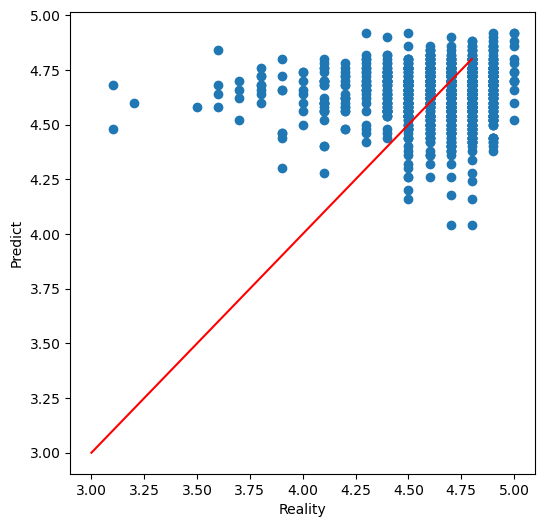

In [5]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(3,5,0.2),np.arange(3,5,0.2),color='red')
plt.scatter(y_test, predictions)
plt.xlabel("Reality")
plt.ylabel("Predict")

**Calculate Loss value using Mean Squared Error (MSE)**

In [6]:
loss_default = mean_squared_error(y_test,predictions)
loss_default

0.07042727272727274

*Because field of dataset in different scale and different currency, it will affect the distance of data point which model KNN depended on to predict. So that these field need to be convert into a suitable range of value to get in model by using `Feature Scaling`*

**Feature Scaling**
- There are `three` methods:
    + Standardisation: Making the dataset have a mean of 0 and a standard deviation of 1, applied in most cases requiring feature scaling.
    + Normalization: Scaling values in the dataset to the range [0, 1], applied when the dataset follows a normal distribution.
    + MinMax Scaler: Scaling values to a range between the minimum and maximum values within the attribute's value range, which could be a range like [-1, 0], [0, 1], [-1, 1],... 

*In this project, I used `Standardisation` to scaling value's range of attribute*

In [7]:
knnModel = Pipeline([('scaler',StandardScaler()),('model',KNeighborsRegressor())])
knnModel.fit(X_train,y_train)
predictions=knnModel.predict(X_test)

**Draw a plot to show the predictions of KNN Models compare with reality value after scaling value's range**

Text(0, 0.5, 'Predict')

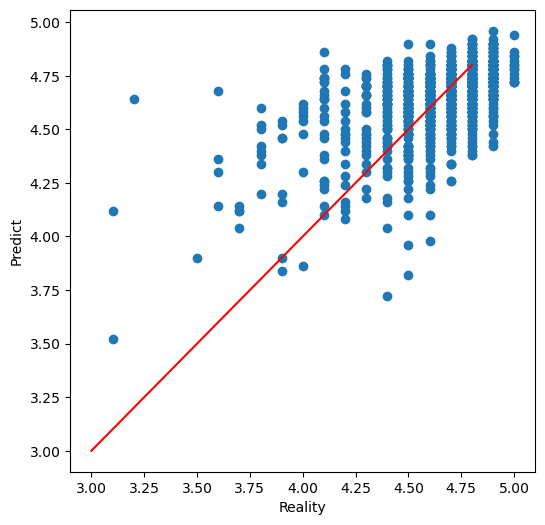

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(3,5,0.2),np.arange(3,5,0.2),color='red')
plt.scatter(y_test, predictions)
plt.xlabel("Reality")
plt.ylabel("Predict")

**Calculate Loss value using Mean Squared Error (MSE)**

In [9]:
loss_standard = mean_squared_error(y_test,predictions)
loss_standard

0.04099405594405595

*Review*
- After doing `Feature Scaling`, the Loss value calculate by MSE was reduced

*Config parameter*
- First, I used kNN Model with k = 5 (standard value of sklearn library) but in this project, k = 5 maybe isn't the best value for the lowest `loss`.
- My mission is find a suitable k-value for this project to get the lowest `loss`, so that I use class `GridSearchCV` and `cross-validation` available in sklearn library:
    + Perform `cross-validation` by dividing the dataset into 5 parts, aiming to evaluate various values of k in multiple scenarios for a more general assessment of the results.
    + Consider k in the range [1, 50] and select the value of k with the highest evaluation score.

- In this project, our group use MSE to calculate `loss value` so I will build a function to calculate.
- Because of the lower loss value are, the better model are, so `loss value` will be calculated by: `negative MSE (-MSE)` 

In [10]:
def mse_score(y_true,y_predict):
    return -mean_squared_error(y_true,y_predict)

**Build model to evalutate `parameter k`**

In [11]:
knnModel = Pipeline([('scaler',StandardScaler()),('model',KNeighborsRegressor())])
mod=GridSearchCV(estimator=knnModel,
                param_grid={'model__n_neighbors':np.arange(1,50)},
                scoring={'mse':make_scorer(mse_score)},
                refit='mse',
                cv=5)
mod.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             refit='mse', scoring={'mse': make_scorer(mse_score)})

**Draw a plot to show evaluate point of each k-value**

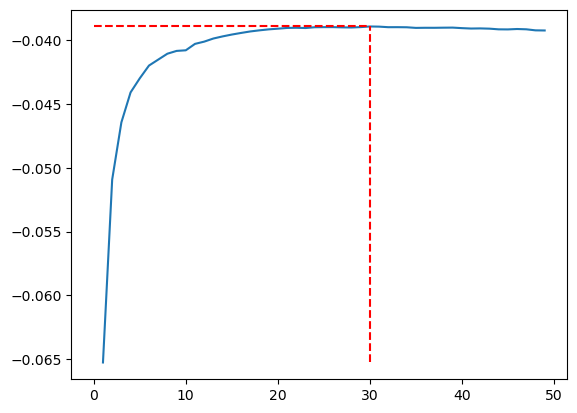

In [12]:
df_result=pd.DataFrame(mod.cv_results_)
plt.plot(df_result['param_model__n_neighbors'],
        df_result['mean_test_mse'])
best_index=list(df_result['param_model__n_neighbors']).index(mod.best_params_['model__n_neighbors'])
best=(
        list(df_result['param_model__n_neighbors'])[best_index],
        list(df_result['mean_test_mse'])[best_index]
)
plt.plot([best[0],best[0]],[df_result['mean_test_mse'].min(),best[1]],
        linestyle='dashed',color='red')
plt.plot([0,best[0]],[best[1],best[1]],
        linestyle='dashed',color='red')

**Get the best k-value**

In [13]:
mod.best_params_

{'model__n_neighbors': 30}

**Apply the best k-value to kNN Model**

In [30]:
modified_knnModel = Pipeline([('scaler',StandardScaler()),('model',
                                KNeighborsRegressor(n_neighbors=mod.best_params_['model__n_neighbors']))])
start_time = time.time()
modified_knnModel.fit(X_train,y_train)
end_time = time.time()
knn_predictions=modified_knnModel.predict(X_test)

**Draw a plot to show the predictions of KNN Models compare with reality value after configing parameter k**

Text(0, 0.5, 'Predict')

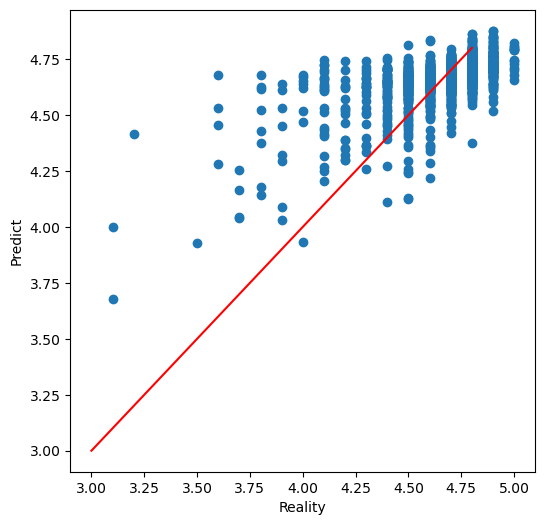

In [24]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(3,5,0.2),np.arange(3,5,0.2),color='red')
plt.scatter(y_test, knn_predictions)
plt.xlabel("Reality")
plt.ylabel("Predict")

**Calculate Loss value using Mean Squared Error (MSE)**

In [16]:
loss = mean_squared_error(y_test, knn_predictions)
loss

0.037237043512043516

**Calculate R2 Score to compare with other models to decide which is the most suitable model**

In [18]:
score = r2_score(y_test, knn_predictions)
score

0.37377519447149743

**Calculate runtime of modified model**

In [31]:
runtime = end_time - start_time
runtime

0.031304121017456055

**Print all calculated value**

In [34]:
print(f"Mean Squared Error: {loss:.4f}")
print(f"R Squared Score: {score:.4f}")
print(f"Runtime: {runtime:.4f} seconds")

Mean Squared Error: 0.0372
R Squared Score: 0.3738
Runtime: 0.0313 seconds
